In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from scipy.optimize import minimize

The dataset presented here is a small synthetic data of the stock prices of the top three selling HVAC companies in the US along with the energy price per unit kwh. The data is small, ranging through a short period (from January 2021 to February 2025) since the goal is merly to demonstrate the ideas behind the analysis.

The goal is to analyze whether energy prices have any impact on the performance of the HVAC industry through analyzing its impact on the stock performance of a portofolio of the three major companies. 

In [19]:
data = pd.read_csv('HVAC.csv')
data.head(5)

,Date,Trane,Watsco,Carrier,Portfolio,% Elec,S&P500
0,1/1/2021,-1.25%,5.27%,2.07%,1.76%,-0.77%,-1.11%
1,2/1/2021,6.90%,1.93%,-5.12%,-0.32%,8.45%,2.61%
2,3/1/2021,8.04%,7.26%,15.58%,11.80%,-2.87%,4.24%
3,4/1/2021,5.00%,12.31%,3.22%,5.52%,-1.94%,5.24%
4,5/1/2021,7.23%,-0.50%,5.39%,4.75%,0.56%,0.55%


Note: The column portfolio is just a wieghted average of the the returns of the companies based on their revenues during 2022. Ideally one should consider an index of HVAC companies but no such index was found.

In [20]:
data['Portfolio'] = data['Portfolio'].str.replace('%', '').astype(float)
data['S&P500'] = data['S&P500'].str.replace('%', '').astype(float)
data['% Elec'] = data['% Elec'].str.replace('%', '').astype(float)

In [21]:
data.dtypes

Date          object
Trane         object
Watsco        object
Carrier       object
Portfolio    float64
% Elec       float64
S&P500       float64
dtype: object

To assess the performance of the companies the market sentiments must be isolated, that is the stock prices of the company reflects additional information than just their performance.
For this sake a simple OLS regression between the created portfolio and the market index is performed and the residuals are saved. These residuals represent the portions of performance attributed only to the companies.

$$ R_{i,t} = \alpha + \beta R_{M,t}$$

In [23]:
y = data['Portfolio']
x = sm.add_constant(data['S&P500'])
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Portfolio   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     76.45
Date:                Tue, 13 May 2025   Prob (F-statistic):           1.70e-11
Time:                        14:43:53   Log-Likelihood:                -147.47
No. Observations:                  50   AIC:                             298.9
Df Residuals:                      48   BIC:                             302.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3946      0.684      0.577      0.5

Text(2, 20, '$y_t = alpha + beta x_t$')

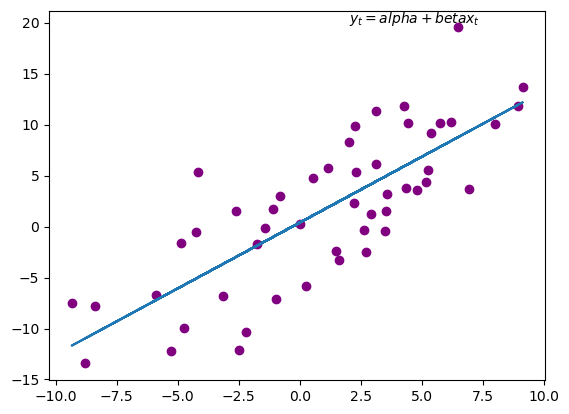

In [42]:
plt.scatter(data['S&P500'], data['Portfolio'] , color = 'purple')
plt.plot(data['S&P500'], 0.3946 + 1.2932*data['S&P500'])
plt.text(2,20,'$y_t = alpha + beta x_t$')

In [43]:
data['Abnormal returns'] = data['Portfolio'] - 0.3946 - 1.2932*data['S&P500']
data.head(5)

,Date,Trane,Watsco,Carrier,Portfolio,% Elec,S&P500,Abnormal returns
0,1/1/2021,-1.25%,5.27%,2.07%,1.76,-0.77,-1.11,2.800852
1,2/1/2021,6.90%,1.93%,-5.12%,-0.32,8.45,2.61,-4.089852
2,3/1/2021,8.04%,7.26%,15.58%,11.80,-2.87,4.24,5.922232
3,4/1/2021,5.00%,12.31%,3.22%,5.52,-1.94,5.24,-1.650968
4,5/1/2021,7.23%,-0.50%,5.39%,4.75,0.56,0.55,3.644140


Once the abonormal returns are created one can check whether there is a proprtional relationship between the changes in the electricity prices and the abnormal returns. In this case it turns out there is no such relation!

In [48]:
y = data['Abnormal returns']
x = sm.add_constant(data['% Elec'])
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Abnormal returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                   0.03731
Date:                Tue, 13 May 2025   Prob (F-statistic):              0.848
Time:                        15:39:39   Log-Likelihood:                -147.45
No. Observations:                  50   AIC:                             298.9
Df Residuals:                      48   BIC:                             302.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0249      0.679     -0.037      0.9

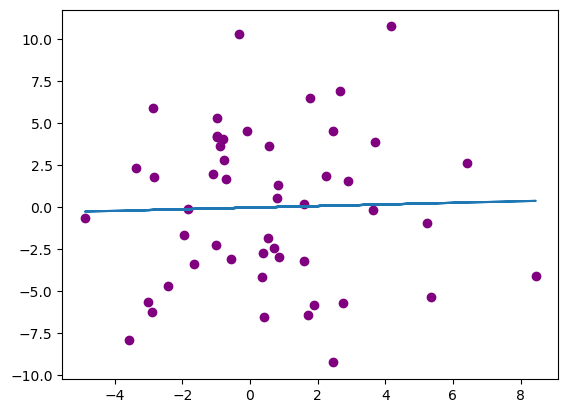

In [50]:
plt.scatter(data['% Elec'], data['Abnormal returns'] , color = 'purple')
plt.plot(data['% Elec'], -0.0249 + 0.0477*data['% Elec'])

Now we consider whether a bivariate VAR model can be useful in describing the relationship between the two series ( the abnormal returns and changes in the electricity prices).


$$ R_{t} = \alpha_{1,0} + \alpha_{1,1} R_{t-1} + \alpha_{1,2} \Delta P_{t-1}$$
$$ \Delta P_{t} = \alpha_{2,0} + \alpha_{2,1} R_{t-1} + \alpha_{1,2} \Delta P_{t-1}$$

To estimate we need to write the likelihood with respect to the multivariate vector: $$Y = [y_1,y_2]$$



$$ \ell(\bold{\theta};Y) = -\frac{Tn}{2}\log(2\pi) - \frac{T}{2}\log(|\Sigma|)  - \frac{1}{2} \sum{(Y - \bold{E}(Y))\Sigma^{-1} (Y - \bold{E}(Y))'}  $$


$$ \Sigma = \begin{bmatrix} 
\sigma_{1}^2  &  \sigma_{12} \\
 \sigma_{12} &  \sigma_{2}^2 
\end{bmatrix}
$$


Note that $(Y - \bold{E}(Y))$ is just the error vector $\bold{\epsilon} = [u_1,u_2]$

$$\bold{\epsilon_t} = [u_{1,t},u_{2,t}] = [y_{1,t} - \alpha_{1,0} - \alpha_{1,1} y_{1,t-1} - \alpha_{1,2} y_{2,t-1}  , y_{2,t} - \alpha_{2,0} - \alpha_{2,1} y_{1,t-1} - \alpha_{2,2} y_{2,t-1}]$$


Finally, the joint likelihood will be found by re_writting the above likelihood as: $n = 2$


$$ \ell(\bold{\theta};Y) = -T \log(2\pi) - \frac{T}{2}\log(|\Sigma|)  - \frac{1}{2} \sum{\bold{\epsilon_t} \Sigma^{-1}\bold{\epsilon_t} '}  $$



In [45]:
def log_likelihood(p,x1,x2):
    a10_hat = p[0]
    a20_hat = p[1]
    a11_hat = p[2]
    a12_hat = p[3]
    a21_hat = p[4]
    a22_hat = p[5]
    gam1_hat = p[6]
    gam2_hat = p[7]
    P  = np.array([[gam1_hat,0], [0,gam2_hat]])
    P_T = np.array([[gam1_hat,0], [0,gam2_hat]])
    V = np.matmul(P,P_T)
    Det_V = np.linalg.det(V)
    V_inv = np.linalg.inv(V)
    u1 = np.zeros(len(x1))
    u2 = np.zeros(len(x2))
    u1[0] = 0
    u2[0] = 0
    for i in range(len(x1)-1):
        u1[i+1] = x1[i+1] - a11_hat*x1[i] - a10_hat - a12_hat*x2[i]
        u2[i+1] = x2[i+1] - a21_hat*x1[i] - a20_hat - a22_hat*x2[i]
    U = np.column_stack((u1,u2))
    L = np.zeros(len(U))
    for i in range (len(U)):
      h_i =   np.matmul(np.matmul(U[i,],V_inv),(U[i,]).reshape(-1,1))
      L[i] = h_i.item()

    l = -(len(U))*np.log(2*np.pi) - 0.5*(len(U))*np.log(Det_V) - 0.5*np.sum(L)
    return -l

In [46]:
#Test the likelihood function:
p0 = [1.5,1,3,0.2, 0.8,0.14,2,4]
ll = log_likelihood(p0,data['Abnormal returns'],data['% Elec'])
ll

1585.6779367997947

In [47]:
minimize(log_likelihood, p0, args= (data['Abnormal returns'],data['% Elec']))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 262.8723463167499
        x: [-3.490e-01  4.072e-01 -2.907e-02  5.647e-01 -1.650e-02
             2.730e-01  4.343e+00  2.588e+00]
      nit: 33
      jac: [ 3.815e-06  0.000e+00  0.000e+00  0.000e+00  3.815e-06
             0.000e+00  3.815e-06  0.000e+00]
 hess_inv: [[ 3.642e-01  2.039e-02 ...  2.269e-02  1.789e-02]
            [ 2.039e-02  1.472e-01 ...  3.563e-03  1.542e-03]
            ...
            [ 2.269e-02  3.563e-03 ...  1.869e-01  1.619e-03]
            [ 1.789e-02  1.542e-03 ...  1.619e-03  5.815e-02]]
     nfev: 369
     njev: 41

$$ R_{t} = -0.349 - 0.029 R_{t-1} + 0.5647^{**} \Delta P_{t-1}$$
$$ \Delta P_{t} = 0.407 - 0.0165 R_{t-1} + 0.273^{*} \Delta P_{t-1}$$

1. The Bivariate VAR suggests lags of the price changes are useful in explaining the returns, but the problem is that postive sign is counter intuitive suggesting that the higher the energy prices the higher the returns!
2. An F-test should be performed to asses whether all the lags are siginificant before using the equation to make any inference.

Conclusion: At this point its addmitted that no conclusive evidence supporting whether energy prices are influencing (postively or negatively) the performance of HVAC companies!

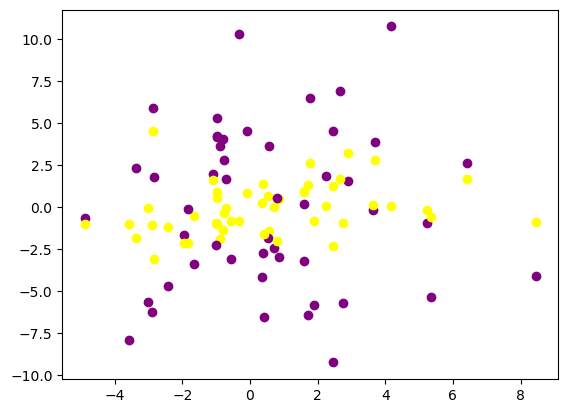

In [56]:
M = np.zeros(len(data['Abnormal returns']))
M[0] = -0.349
for i in range (len(data['Abnormal returns'])-1):
      M[i+1] =   -0.349 - 0.029 *data['Abnormal returns'][i] + 0.5647* data['% Elec'][i]
      plt.scatter(data['% Elec'][i], data['Abnormal returns'][i] , color = 'purple')
      plt.scatter(data['% Elec'][i], M[i] , color = 'yellow')
   